In [1]:
import numpy as np
from numpy import random
import cv2
from skimage import io
from skimage.color import rgb2hsv
import skimage.segmentation as seg
from scipy.spatial.distance import pdist
from skimage.feature import local_binary_pattern
from skimage.measure import regionprops
from skimage.feature import greycomatrix, greycoprops

import pandas as pd
import sys

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set(style="ticks", color_codes=True)


# My funcs 
sys.path.append('/home/dzyga/My/Python/')
from  utils import show_image

%matplotlib inline

/home/dzyga/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [44]:
fold = '/home/dzyga/Downloads/'
fname = 'sky_parquet.jpg'

parquet = io.imread(fold+'parquet.jpg')
grass = io.imread(fold+'grass.jpeg')
sky = io.imread(fold+'sky.jpg')

img = io.imread(fold+fname)
hsvimg = rgb2hsv(img)
simg = hsvimg[:,:,1]
show_image(img)

In [3]:
img.shape

(960, 1280, 3)

In [4]:
mask_floor = np.zeros(simg.shape)
mask_floor[470:,600:1000] = 1
mask_nonfloor = np.zeros(simg.shape)
mask_nonfloor[:, :350] = 1
plt.imshow(mask_floor*simg)

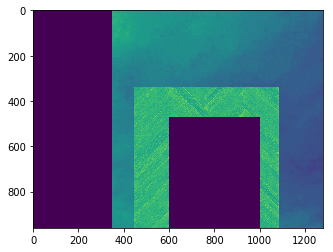

In [5]:
mask_interest = np.logical_not(mask_floor + mask_nonfloor)
plt.imshow(mask_interest*simg)
segments = np.array_split(mask_interest,5)

In [33]:
from skimage.segmentation import slic, mark_boundaries
from skimage.color import label2rgb
num_segmnts = 50
slic_img = slic(img, n_segments = num_segmnts, sigma = 5, compactness = 7)

io.imshow(label2rgb(slic_img, img))
plt.axis('off'); 
print('Number of unique labels is ', len(np.unique(img_labels_slic)))

Number of unique labels is  284


In [36]:
slic_floor = (slic_img*mask_floor).astype('int')
slic_nonfloor = (slic_img*mask_nonfloor).astype('int')
slic_interes = (slic_img*mask_interest).astype('int')

segments_floor = regionprops(slic_floor, simg)
segments_nonfloor = regionprops(slic_nonfloor, simg)

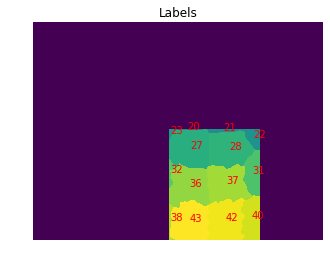

In [37]:
plt.imshow(slic_floor);
# plt.imshow(mask_interest)
for props in segments_floor:
    cx, cy = props.centroid  # centroid coordinates
    plt.text(int(cy), int(cx), props.label, fontsize=10, color='red')
plt.axis('off')#
plt.title('Labels');

In [38]:
def get_glcm_features(patch):
    """fet glcm feature for the input patch
    of an image """
    patch = cv2.convertScaleAbs(patch)
    # list of GLCM feature 
    features = [
     'dissimilarity', 
     'homogeneity', 
     'energy',
     'correlation',
     'contrast',
     'ASM']

    N = len(features)
    feature_vec = np.zeros(N)
    glcm_img = greycomatrix(patch, [5], [0, np.pi/4, np.pi/2, 3*np.pi/4],
                            levels=256, normed=True)
    for j,f in enumerate(features):
        feature_vec[j] = greycoprops(glcm_img, f)[0,0]
    return feature_vec.reshape(1,-1)
# get_glcm_features(patch)

In [46]:
g_grass = get_glcm_features(grass[:,:,0])
g_parquet = get_glcm_features(parquet[:,:,0])
g_sky = get_glcm_features(sky[:,:,0])

In [48]:
data_g = np.vstack((g_grass, g_parquet, g_sky))
df_g = pd.DataFrame(data_g)
sns.pairplot(df_g)

### Floor 

In [39]:

N = (get_glcm_features(segments_floor[0].intensity_image.squeeze())).shape[1]
M = len(segments_floor) 
feature_matr = np.zeros([M,N])
for i,props in enumerate(segments_floor):
    feature_matr[i, :] = get_glcm_features(props.intensity_image.squeeze())

df = pd.DataFrame(feature_matr)
# df.columns = ['dissimilarity', 'homogeneity', 'energy', 'contrast','contrast','ASM']
sns.pairplot(df);
# df
# check 
x1 = 1
x2 = 4
# plt.scatter(feature_matr[:, x1],feature_matr[:, x2])

### Not a floor

In [ ]:

N = (get_glcm_features(segments_floor[0].intensity_image.squeeze())).shape[1]
M = len(segments_nonfloor) 
feature_matr = np.zeros([M,N])
for i,props in enumerate(segments_nonfloor):
    feature_matr[i, :] = get_glcm_features(props.intensity_image.squeeze())

df1 = pd.DataFrame(feature_matr)
df1.columns = ['dissimilarity', 'homogeneity', 'energy', 'contrast','contrast','ASM']
sns.pairplot(df1);

## Gabor  features

In [ ]:
# def build_filters():
#     filters = []
#     ksize = 31
#     for theta in np.arange(0, np.pi, np.pi / 16):
#         kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
#         kern /= 1.5*kern.sum()
#         filters.append(kern)
#     return filters
 
# def process(img, filters):
#     accum = np.zeros_like(img)
#     for kern in filters:
#         fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
#         np.maximum(accum, fimg, accum)
#     return accum

In [ ]:
from skimage.util import img_as_float
from skimage.filters import gabor_kernel
from scipy import ndimage as nd

def compute_kernels():
    kernels = []
    for theta in range(4):
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            for frequency in (0.05, 0.25):
                kernel = np.real(gabor_kernel(frequency, theta=theta,
                                              sigma_x=sigma, sigma_y=sigma))
                kernels.append(kernel)
    return kernels

In [ ]:
def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = nd.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats

In [ ]:
def match(feats, ref_feats):
    min_error = np.inf
    min_i = None
    for i in range(ref_feats.shape[0]):
        error = np.sum((feats - ref_feats[i, :])**2)
        if error < min_error:
            min_error = error
            min_i = i
    return min_i

In [ ]:
# prepare reference features
kernels = compute_kernels()

# Floor - label 1
N = len(kernels)
M1= len(segments_floor) 
gabor_matr = np.zeros([M1,N,2], dtype=np.double)
for i,props in enumerate(segments_floor):
    gabor_matr[i, :, :] = compute_feats(props.intensity_image.squeeze(),kernels)

df1 = pd.DataFrame(gabor_matr[:,:,0])

In [ ]:
# Non Floor - label 0
# N = len(kernels)
M0 = len(segments_nonfloor) 
gabor_matr = np.zeros([M0,N,2], dtype=np.double)
for i,props in enumerate(segments_nonfloor):
    gabor_matr[i, :, :] = compute_feats(props.intensity_image.squeeze(),kernels)

df0 = pd.DataFrame(gabor_matr[:,:,0])

In [ ]:
def garbour_data(segments, kernels, label):
    N = len(kernels)
    M = len(segments) 
    gabor_matr = np.zeros([M,N,2], dtype=np.double)
    for i,props in enumerate(segments):
        gabor_matr[i, :, :] = compute_feats(props.intensity_image.squeeze(),kernels)
#     df = pd.DataFrame(gabor_matr[:,:,0])
#     df['label'] = np.ones(M, dtype='uint') * label
    
    return np.hstack((gabor_matr[:,:,0], np.ones(M, dtype='uint')[:,None] * label))

In [ ]:
data1 = garbour_data(segments_floor, kernels, int(1))
data0 = garbour_data(segments_nonfloor, kernels, int(0))

In [ ]:
data = np.vstack((data1,data0))
X = data[:,:-1]
y = data[:,-1]

In [ ]:
# check 
x1 = 15
x2 = 4
# plt.scatter(gabor_matr[:, x1, 0], gabor_matr[:, x2, 0])
plt.scatter(X[:, x1], X[:, x2])

## LBP features 

In [ ]:
def get_lbp_features(patch):
    patch = cv2.convertScaleAbs(patch)
    radius = 3
    n_points = 8 * radius
    lbp_methods = ['uniform',
               'default', 
               'ror',
               'nri_uniform',
               'var']
    Nbins = 8
    for method in lbp_methods:
        lbp_patch = np.zeros([Mlbp, Nbins])
        lbp  = local_binary_pattern(patch, n_points, radius, method)
        feature_hist, _ = np.histogram(lbp, bins = Nbins)
        lbp_matr[i, :] = feature_hist
    feature_matr = np.hstack((feature_matr,lbp_matr))

## Clussification

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [ ]:
classifier = SVC(gamma=0.001)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
classifier.fit(X_train, y_train)
predicted = classifier.predict(X_test)


In [ ]:
predicted

In [ ]:
X_train.shape

In [60]:
n = 10
m = 8

# imh, imw = simg.shape 
scol = int(imh/m)
srow = int(imh/n)

# patches = []
# for i in range(m):
#     for j in range(n):
#         patches.append(simg[i:i+srow, j:j+scol])
        
patches = [ img[i*srow:(i+1)*srow, j*scol:(j+1)*scol] for i in range(m) for j in range(n)]     # simg[i:i+srow, j:j+scol]

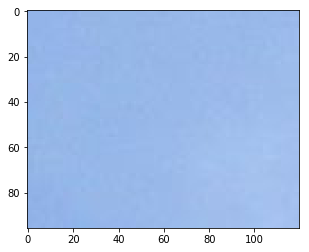

In [70]:
plt.imshow(patches[40])

In [66]:
len(patches)

80